Initial preparation by Valery Ilin

Modified by: Elvira Zainulina

Post modif: Valery Ilin

In [46]:
import pyrealsense2 as rs
import open3d as o3d
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation as R
from mpl_toolkits.mplot3d import Axes3D
import time

# Collecting frames for next dev

In [47]:
count_of_frames = 18
frames_between_frames_D435 = 20

In [48]:
count_of_frames * frames_between_frames_D435 / 30

12.0

# Iitial configs

In [49]:
# data filenames
d435_filename = '../data/D435.bag'
t265_filename = '../data/T265.bag'

In [50]:
# config fo D435
cfg_d435 = rs.config()
cfg_d435.enable_device_from_file(d435_filename)
cfg_d435.enable_stream(rs.stream.depth, 848, 480, rs.format.z16, 30)
pipe_d435 = rs.pipeline()

In [51]:
# config fo T265
cfg_t265 = rs.config()
cfg_t265.enable_device_from_file(t265_filename)
cfg_t265.enable_stream(rs.stream.pose)
pipe_t265 = rs.pipeline()


# Get all data from 265

In [54]:
cfg = rs.config()
cfg.enable_device_from_file(t265_filename)
cfg.enable_stream(rs.stream.pose)
pipe = rs.pipeline()
profile = pipe.start(cfg)

t265_data_list = []
t265_time_list = []
first_timestamp = None
while(True):

    frames = pipe.wait_for_frames()
    pose = frames.get_pose_frame()
    
    if pose:
        if pose.get_timestamp() == first_timestamp:
            print('reached the first frame - reading bag file completed')
            break
        if first_timestamp is None:
            first_timestamp = pose.get_timestamp()
            print('initial_timestamp',first_timestamp)
#         print('current-first',pose.get_timestamp()-first_timestamp)
        t265_data_list.append(pose.get_pose_data())
        t265_time_list.append(pose.get_timestamp())
    
pipe.stop()

initial_timestamp 1585059273040.0645
reached the first frame - reading bag file completed


In [55]:
len(t265_data_list)

6147

In [124]:
def get_translation_pose_from_data(pose):
    # https://github.com/IntelRealSense/librealsense/issues/5178
    try:
        trans = pose.translation
#         return np.array([-trans.z, trans.x, -trans.y]) # world(x,y,z) = real(-z,x,-y)
        return np.array([trans.x, trans.y, trans.z]) # world(x,y,z) = real(-z,x,-y)
    except:
        return

In [66]:
t265_frames_all = t265_data_list

In [68]:
get_translation_pose_from_data(t265_frames_all[60])


array([-0.00075021, -0.00132552, -0.00054592])

## Collecting frames

In [69]:
d435_frames = []
pipe_d435.start(cfg_d435)
while len(d435_frames) != count_of_frames:
    for i in range(frames_between_frames_D435):
        depth_frame = pipe_d435.wait_for_frames().get_depth_frame()
    d435_frames.append(depth_frame)

In [70]:
pipe_t265.start(cfg_t265)

pose_frame = None
pose_frame_time = -1
thresh = 7
t265_frames = []
t265_frames_temp = []
n = 0

for i, depth_frame in enumerate(d435_frames):
    depth_frame_time = depth_frame.get_timestamp()
    while abs(depth_frame_time-pose_frame_time) > thresh:
        pose_frame = pipe_t265.wait_for_frames().get_pose_frame()
        pose_frame_time = pose_frame.get_timestamp()
    while abs(depth_frame_time-pose_frame_time) <= thresh:
        pose_frame = pipe_t265.wait_for_frames().get_pose_frame()
        t265_frames_temp.append(pose_frame)
        pose_frame_time = pose_frame.get_timestamp()

    min_int_index = 0
    min_interval = thresh * 2
    for ind_pose, temp_pose in enumerate(t265_frames_temp):
        if abs(depth_frame_time-temp_pose.get_timestamp())<min_interval:
            min_interval = abs(depth_frame_time-temp_pose.get_timestamp())
            min_int_index = ind_pose
    t265_frames.append(t265_frames_temp[min_int_index])
    

## Test for frames

In [71]:
def count_diff_frames(frames):
    prev_frame = None
    for i, frame in enumerate(frames):
        if prev_frame is not None:
            print("Difference bw {0} and {1} frames is {2:.4f} ms".format(i, i-1, frame.get_timestamp()-prev_frame.get_timestamp()))
        prev_frame = frame

In [72]:
def get_diff_sensors(frames1, frames2):
    if len(frames1) != len(frames2):
        return
    else:
        for i in range(len(frames1)):
            print("Difference bw frames1[{0}] and frames2[{0}] frames is {1:.4f} ms".format(i, frames1[i].get_timestamp()-frames2[i].get_timestamp()))
        

In [73]:
count_diff_frames(d435_frames)
count_diff_frames(t265_frames)

Difference bw 1 and 0 frames is 667.1113 ms
Difference bw 2 and 1 frames is 667.8394 ms
Difference bw 3 and 2 frames is 666.3208 ms
Difference bw 4 and 3 frames is 667.0376 ms
Difference bw 5 and 4 frames is 667.0586 ms
Difference bw 6 and 5 frames is 667.0928 ms
Difference bw 7 and 6 frames is 666.9907 ms
Difference bw 8 and 7 frames is 667.1167 ms
Difference bw 9 and 8 frames is 667.2759 ms
Difference bw 10 and 9 frames is 666.8425 ms
Difference bw 11 and 10 frames is 667.1030 ms
Difference bw 12 and 11 frames is 667.1931 ms
Difference bw 13 and 12 frames is 666.9944 ms
Difference bw 14 and 13 frames is 667.0403 ms
Difference bw 15 and 14 frames is 667.1030 ms
Difference bw 16 and 15 frames is 668.0032 ms
Difference bw 17 and 16 frames is 666.1301 ms
Difference bw 1 and 0 frames is 669.8936 ms
Difference bw 2 and 1 frames is 664.9299 ms
Difference bw 3 and 2 frames is 670.0322 ms
Difference bw 4 and 3 frames is 664.7439 ms
Difference bw 5 and 4 frames is 665.0342 ms
Difference bw 6 a

In [74]:
get_diff_sensors(d435_frames, t265_frames)

Difference bw frames1[0] and frames2[0] frames is 0.9553 ms
Difference bw frames1[1] and frames2[1] frames is -1.8269 ms
Difference bw frames1[2] and frames2[2] frames is 1.0825 ms
Difference bw frames1[3] and frames2[3] frames is -2.6289 ms
Difference bw frames1[4] and frames2[4] frames is -0.3352 ms
Difference bw frames1[5] and frames2[5] frames is 1.6892 ms
Difference bw frames1[6] and frames2[6] frames is -0.9207 ms
Difference bw frames1[7] and frames2[7] frames is 1.0940 ms
Difference bw frames1[8] and frames2[8] frames is -1.6763 ms
Difference bw frames1[9] and frames2[9] frames is 0.7349 ms
Difference bw frames1[10] and frames2[10] frames is -2.3645 ms
Difference bw frames1[11] and frames2[11] frames is -0.1545 ms
Difference bw frames1[12] and frames2[12] frames is -2.8552 ms
Difference bw frames1[13] and frames2[13] frames is -0.7395 ms
Difference bw frames1[14] and frames2[14] frames is 1.3357 ms
Difference bw frames1[15] and frames2[15] frames is -1.3850 ms
Difference bw fram

# Analysis

## Helpers

In [75]:
import time
from functools import wraps

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        time_start = time.time()
        result = f(*args, **kw)
        time_end = time.time()
        print('----------func:%r took: %2.4f sec' % (f.__name__, time_end-time_start))
        return result
    return wrap

In [76]:
tm_T265toD435 = np.array([[0.999968402, -0.006753626, -0.004188075, -0.015890727],
                          [-0.006685408, -0.999848172, 0.016093893, 0.028273059],
                          [-0.004296131, -0.016065384, -0.999861654, -0.009375589],
                          [0, 0, 0, 1]])

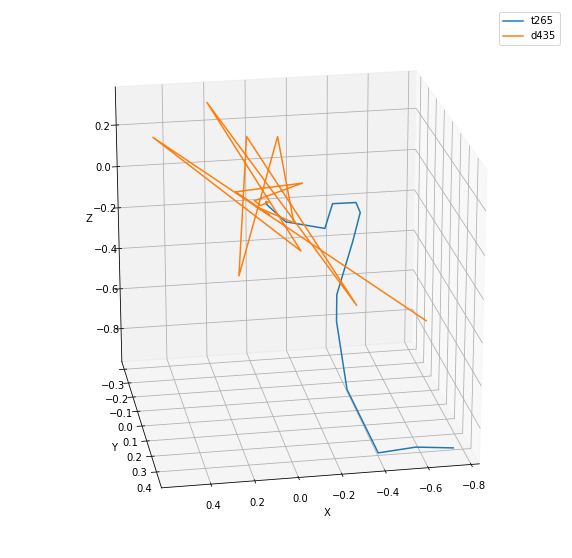

In [77]:
# Graph plot
t265 = np.load('../logs/points_trajectory_T265.npy') #np array coords
d435 = np.load('../logs/points_trajectory_D435.npy')/1 # np array coords
# before = 10
before = d435.shape[0]
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.plot(t265[:before, 0], t265[:before, 1], t265[:before, 2], label='t265')
ax.plot(d435[:before, 0], d435[:before, 1], d435[:before, 2], label='d435')
ax.view_init(elev=22, azim=80)
plt.legend()

## Functions

In [78]:
def get_transformation265(pose):
    data = pose.get_pose_data()
    data_rot = [float(i.strip('xyzw: ')) for i in str(data.rotation).split(', ')]
    r = R.from_quat(data_rot)
    rotation = np.array(r.as_dcm())
    translation = np.array([float(i.strip('xyzw: ')) for i in str(data.translation).split(', ')])[np.newaxis].T
    T = np.hstack((rotation, translation))
    T = np.vstack((T, np.array([0, 0, 0, 1])))
    return T

In [127]:
def get_translation_pose(pose):
    # https://github.com/IntelRealSense/librealsense/issues/5178
    try:
        data = pose.get_pose_data()
        trans = data.translation
        return np.array([trans.x, trans.y, trans.z]) # world(x,y,z) = real(-z,x,-y)
#         return np.array([-trans.z, trans.x, -trans.y]) # world(x,y,z) = real(-z,x,-y)
    except:
        return

In [80]:
get_translation_pose(t265_frames[0])

array([-0.00040176, -0.00104596, -0.00026294])

In [128]:
t265_translations = np.array([get_translation_pose(pose) for pose in t265_frames])
t265_translations

array([[-1.04596128e-03,  2.62938702e-04,  4.01764933e-04],
       [-3.31240473e-04,  7.00565637e-04,  6.70539390e-04],
       [-6.62964361e-04,  4.73686028e-04,  6.18782768e-04],
       [ 6.25264132e-03,  9.78688896e-03, -4.76792548e-03],
       [-3.80775183e-02,  1.19715877e-01, -1.46892965e-02],
       [-1.64789796e-01,  2.72130191e-01,  2.26931386e-02],
       [-2.04936981e-01,  2.92144507e-01,  1.06496386e-01],
       [-2.44872600e-01,  3.91821265e-01,  2.36403316e-01],
       [-2.84007132e-01,  4.22199041e-01,  2.24028617e-01],
       [-3.04414630e-01,  4.13203418e-01,  1.61078975e-01],
       [-2.77537107e-01,  4.07150269e-01,  5.25990091e-02],
       [-2.05385894e-01,  4.11045611e-01, -1.50137872e-01],
       [-2.21029937e-01,  3.88407320e-01, -2.57075280e-01],
       [-1.93955824e-01,  4.03617442e-01, -4.07339901e-01],
       [-2.39451855e-01,  4.31048602e-01, -6.03843987e-01],
       [-3.63571167e-01,  4.46486831e-01, -8.98620486e-01],
       [-4.98134792e-01,  4.31384772e-01

In [82]:
get_transformation265(t265_frames[0])

/home/valeryilin/workdir/skoltech/term3/perceptionRobotics/final_pr_team2/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `as_dcm` is deprecated!
as_dcm is renamed to as_matrix in scipy 1.4.0 and will be removed in scipy 1.6.0
  """


array([[ 9.99955849e-01, -8.59740867e-03, -3.79267864e-03,
        -1.04596000e-03],
       [ 8.67450107e-03,  9.99745994e-01,  2.08014471e-02,
         2.62939000e-04],
       [ 3.61287674e-03, -2.08334283e-02,  9.99776433e-01,
         4.01765000e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [83]:
def apply_transformation(transformation, points):
    """

    :param transformation: 4x4 np.array
    :param points: Nx3 np.array
    :return: transformed Nx3 np.array
    """
    if transformation is None or points is None:
        return None
    else:
        coordinates = np.hstack((points, np.ones((points.shape[0], 1))))
        return (transformation @ coordinates.T).T[:, :-1]

In [84]:
def get_coordinates(depth_frame, make_sampling=True, koef = 2**2):
    """
     TODO
    :param make_sampling:
    :return:
    """
    pc = rs.pointcloud()
    if make_sampling:
        decimate = rs.decimation_filter()
        decimate.set_option(rs.option.filter_magnitude, koef)
        depth_frame = decimate.process(depth_frame)

        points = pc.calculate(depth_frame).as_points()
    else:
        points = pc.calculate(depth_frame).as_points()

    coordinates = np.ndarray(buffer=points.get_vertices(), dtype=np.float32, shape=(points.size(), 3))
    coordinates = coordinates[coordinates[:, 2] != 0]

    coordinates = apply_transformation(tm_T265toD435, coordinates)
    return coordinates


In [85]:
get_coordinates(d435_frames[0]).shape

(23302, 3)

In [86]:
def convert_to_pcl(points):
    """
        TODO
    :param points: Nx3
    :return:
    """
    if points is None:
        return None
    else:
        return o3d.geometry.PointCloud(o3d.utility.Vector3dVector(points))

In [87]:
convert_to_pcl(get_coordinates(d435_frames[0]))

geometry::PointCloud with 23302 points.

In [88]:
# TODO this 100%

def get_transformation435(self, max_point_pair_dist=0.2, init_guess=np.eye(4)):
    old_point_cloud = self.apply_transformation(self.prev_tm, self.point_cloud)
    old_pcl = self.convert_to_pcl(old_point_cloud) # n-1
    self.point_cloud = self.apply_transformation(self.prev_tm, self.get_coordinates())
    if old_pcl is None:
        self.prev_tm = init_guess
        print("\n\n\n{}\n\n\n".format(init_guess))
        return None

    new_pcl = self.convert_to_pcl(self.point_cloud) # n

    tr_mx = o3d.registration.registration_icp(old_pcl, new_pcl, max_point_pair_dist,
                                              self.prev_tm, o3d.registration.TransformationEstimationPointToPoint())\
        .transformation
    self.prev_tm = tr_mx
    return tr_mx

In [89]:
def plot_PC(Y, TX, ax=None, plot_lines=True):
    ax_is_None = False
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax_is_None = True
    ax.plot(Y[:,0], Y[:,1], Y[:,2], 'o', label='source points')
    ax.plot(TX[:,0], TX[:,1], TX[:,2], 'o', label='dest points')
    if plot_lines:
        for i in range(Y.shape[0]):
            ax.plot([Y[i,0], TX[i,0]], [Y[i,1], TX[i,1]], [Y[i,2], TX[i,2]], 
                    'g--')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.legend()
    
    if ax_is_None:
        plt.tight_layout()
        plt.show()

# Visualisation

In [90]:
d435_frames

In [91]:
t265_frames

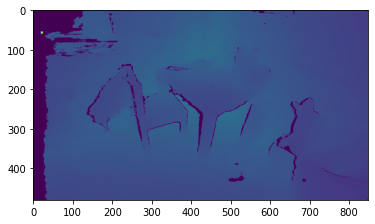

In [122]:
%matplotlib inline
from IPython.display import clear_output

for i in range(len(d435_frames)):
    clear_output(wait=True)
    plt.imshow(d435_frames[i].get_data())
    plt.show()

In [93]:
points = [get_coordinates(depth) for depth in d435_frames]
pcl = [convert_to_pcl(point) for point in points]

In [94]:
@timing
def registration_icp(prev_pc, new_pc, thresh):
    """
    TODO
    """
    return o3d.registration.registration_icp(prev_pc, new_pc, thresh)

In [95]:
regs = []
tr_mxs = []

for i in range(1, len(points)):
    reg = registration_icp(pcl[i-1], pcl[i], 5)
#     print(i, reg.fitness, reg.inlier_rmse)
    tr_mx = reg.transformation
    regs.append(reg)
    tr_mxs.append(tr_mx)

----------func:'registration_icp' took: 0.0971 sec
----------func:'registration_icp' took: 0.1027 sec
----------func:'registration_icp' took: 0.6331 sec
----------func:'registration_icp' took: 0.7527 sec
----------func:'registration_icp' took: 0.4979 sec
----------func:'registration_icp' took: 0.5161 sec
----------func:'registration_icp' took: 0.5639 sec
----------func:'registration_icp' took: 0.4651 sec
----------func:'registration_icp' took: 0.5421 sec
----------func:'registration_icp' took: 1.1807 sec
----------func:'registration_icp' took: 0.4772 sec
----------func:'registration_icp' took: 0.6025 sec
----------func:'registration_icp' took: 0.4678 sec
----------func:'registration_icp' took: 0.4322 sec
----------func:'registration_icp' took: 0.4571 sec
----------func:'registration_icp' took: 0.6653 sec
----------func:'registration_icp' took: 0.4837 sec


In [96]:
fitness_points = [reg.fitness for reg in regs]
inlier_rmse_points = [reg.inlier_rmse for reg in regs]

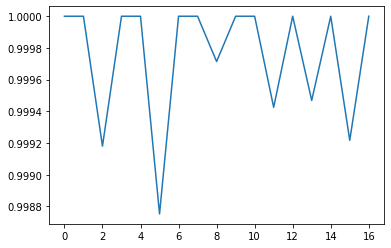

In [97]:
plt.plot(fitness_points)

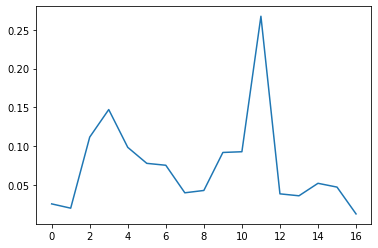

In [98]:
plt.plot(inlier_rmse_points)

In [99]:
def visualise_transf(points0, points1, reg, size=30):
    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')
    cor = np.asarray(reg.correspondence_set)
    set0 = points0[cor[:, 0]]
    set1 = points1[cor[:, 1]]
    inds = np.random.choice(len(cor), size=size, replace=False)
    set0 = set0[inds]
    set1 = set1[inds]
    plot_PC(set0, set1, ax1)
    Tset0 = (reg.transformation @ (np.vstack((set0.T, np.ones(set0.shape[0]))))).T
    plot_PC(Tset0, set1, ax2)
    plt.tight_layout()
    plt.show()
    return set0, set1, Tset0


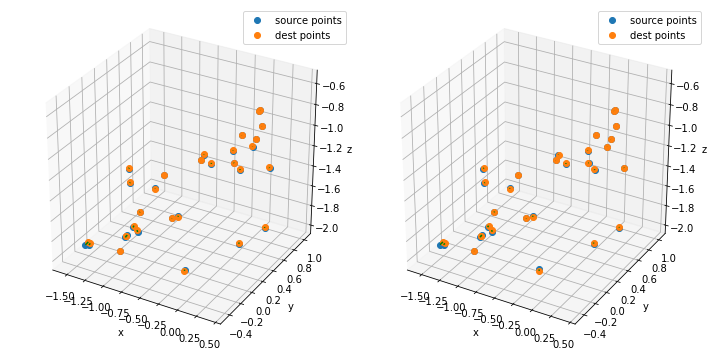

In [100]:
set0, set1, Tset0 = visualise_transf(points[0], points[1], regs[0])

In [101]:
trajectory = [np.zeros(3)]
R_ = np.eye(3)
poses = [R_]

In [102]:
for i in range(len(tr_mxs)):
    t_est = tr_mxs[0][:3, -1]
    R_est = tr_mxs[0][:3, :3]

    R_ = R_est @ R_
    t = trajectory[-1] + (np.linalg.inv(R_) @ t_est).ravel()
    
    trajectory.append(t) #-t moves point cloud into (0,0) of the initial state 
    poses.append(R_) #R_^-1 translates point cloud into the state of initial frame

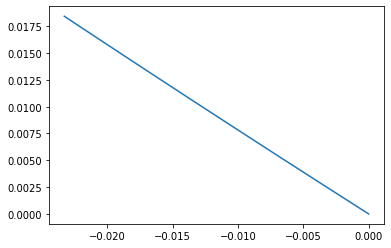

In [103]:
trajectory = np.array(trajectory)
plt.plot(trajectory[:, 1], trajectory[:, 2])

In [104]:
poses

[array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]),
 array([[ 9.99999949e-01,  1.47637264e-04,  2.84455972e-04],
        [-1.47299457e-04,  9.99999284e-01, -1.18721223e-03],
        [-2.84631045e-04,  1.18717027e-03,  9.99999255e-01]]),
 array([[ 9.99999795e-01,  2.95612113e-04,  5.68736440e-04],
        [-2.94260883e-04,  9.99997138e-01, -2.37446463e-03],
        [-5.69436733e-04,  2.37429678e-03,  9.99997019e-01]]),
 array([[ 9.99999538e-01,  4.43924323e-04,  8.52840975e-04],
        [-4.40884057e-04,  9.99993560e-01, -3.56175539e-03],
        [-8.54416632e-04,  3.56137774e-03,  9.99993293e-01]]),
 array([[ 9.99999178e-01,  5.92573669e-04,  1.13676915e-03],
        [-5.87168756e-04,  9.99988551e-01, -4.74908273e-03],
        [-1.13957031e-03,  4.74841136e-03,  9.99988077e-01]]),
 array([[ 9.99998716e-01,  7.41559926e-04,  1.42052053e-03],
        [-7.33114760e-04,  9.99982110e-01, -5.93644486e-03],
        [-1.42489734e-03,  5.93539583e-03,  9.99981370e-01]]),
 array(

In [105]:
def plot_pose(c, pose, ax):
    for i, color in enumerate(['r', 'g', 'b']):
        ax.plot([c[0], pose[0, i]+c[0]], 
                [c[1], pose[1, i]+c[1]],
                [c[2], pose[2, i]+c[2]], color)
    
def plot_poses(trajectory, poses):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(trajectory[:,0], trajectory[:, 1], trajectory[:,2], 'k')
    for i, pose in enumerate(poses):
        plot_pose(trajectory[i], pose, ax)
#     ax.plot(points_trajectory_T265[:,0], points_trajectory_T265[:, 1], points_trajectory_T265[:, 2])
    plt.tight_layout()
    plt.show()

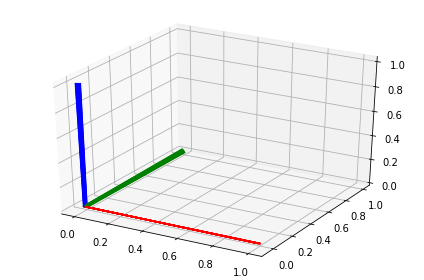

In [106]:
plot_poses(np.array(trajectory), np.array(poses))

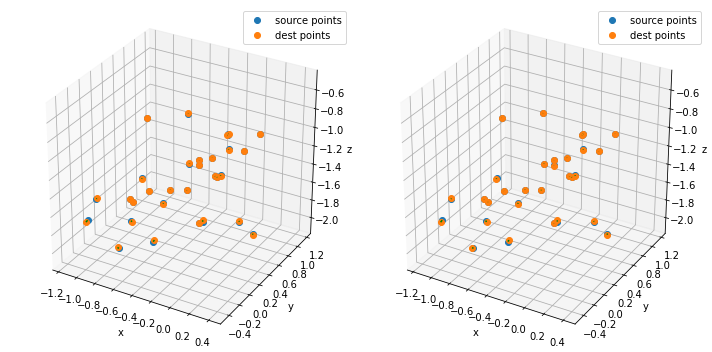

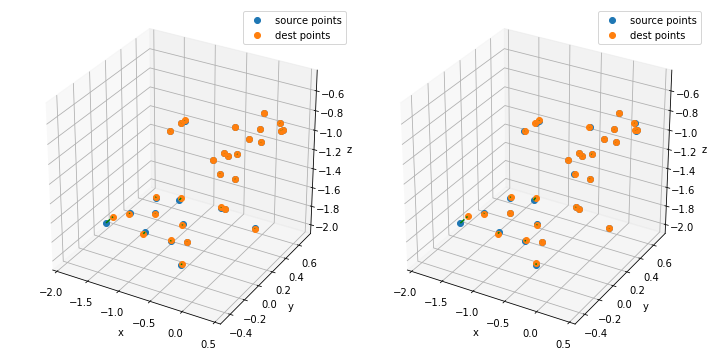

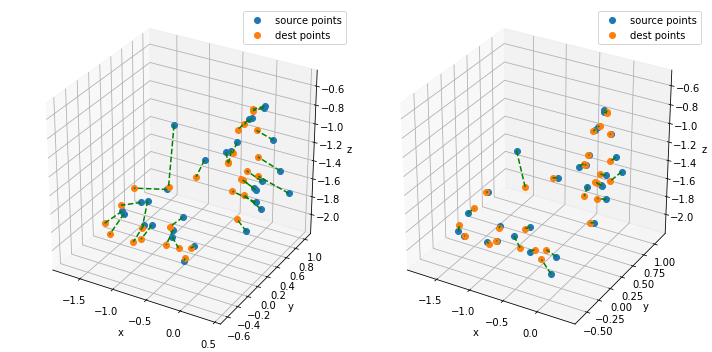

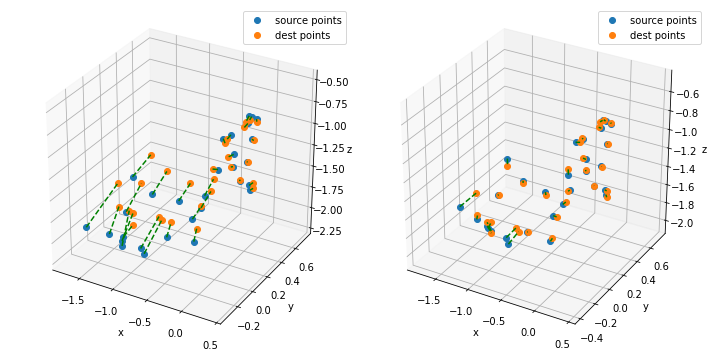

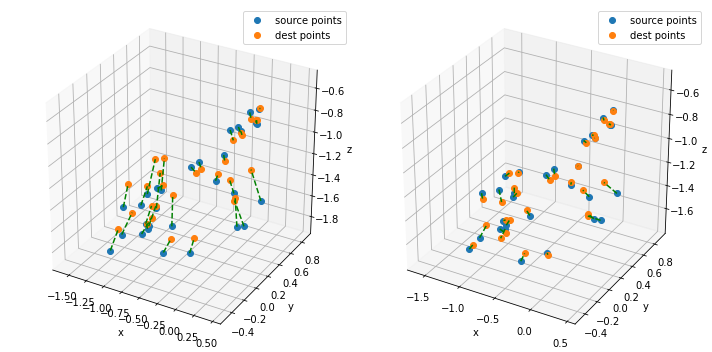

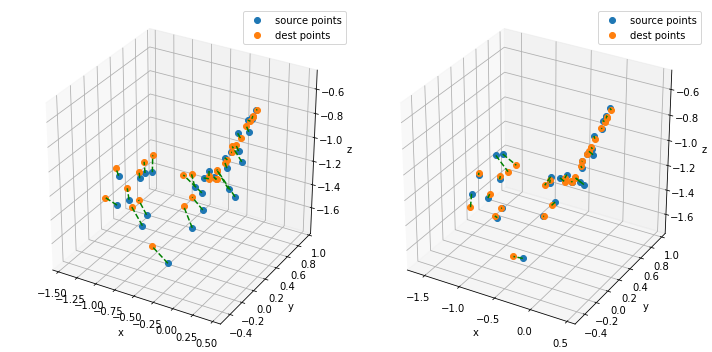

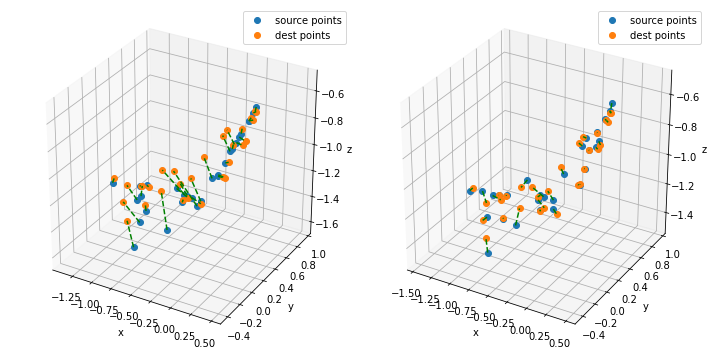

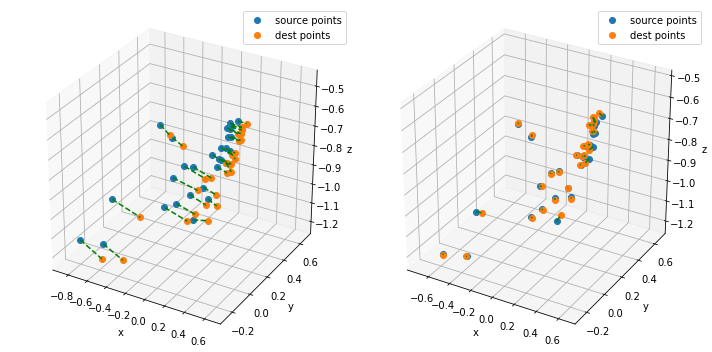

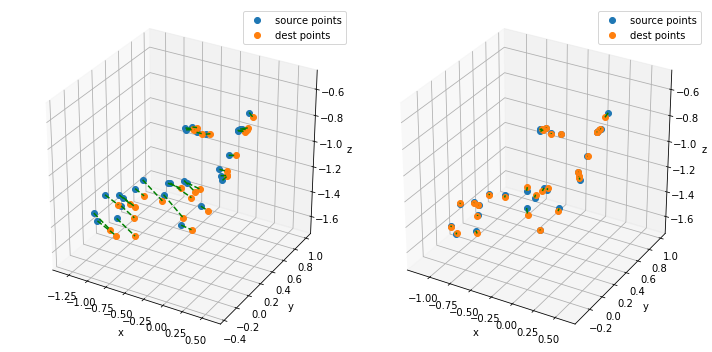

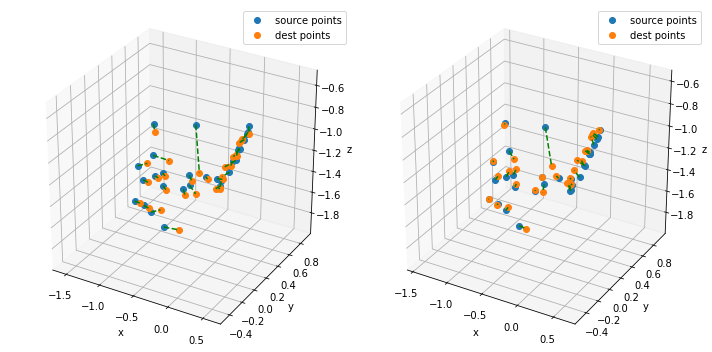

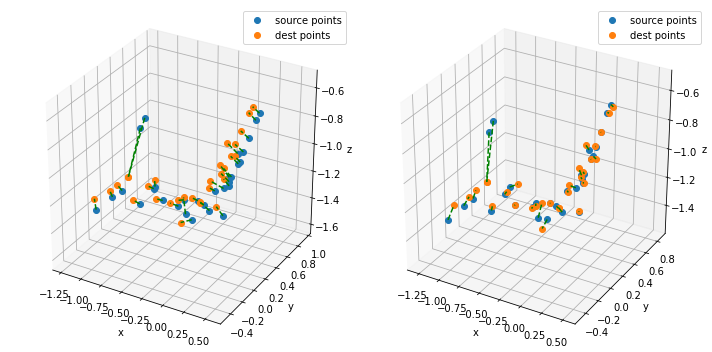

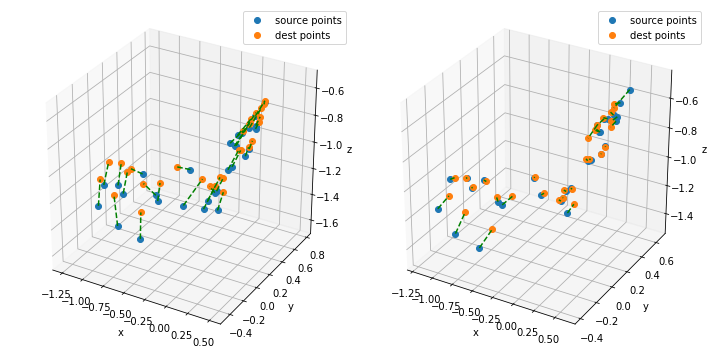

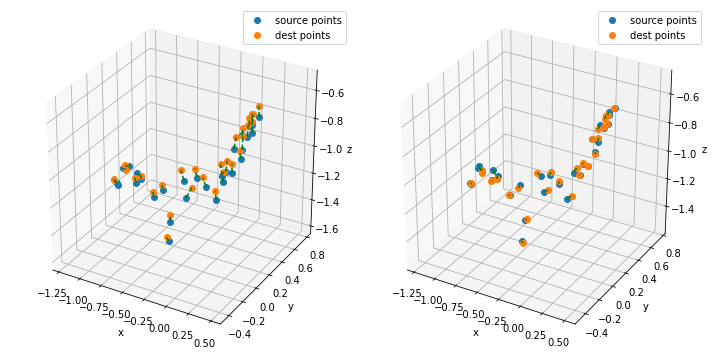

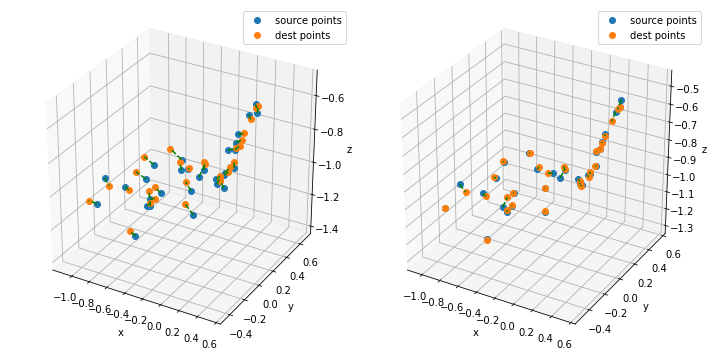

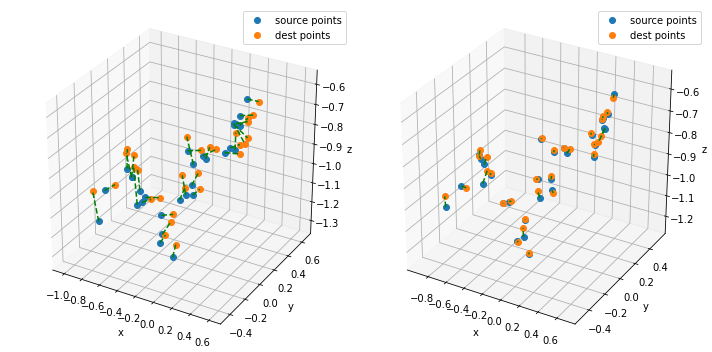

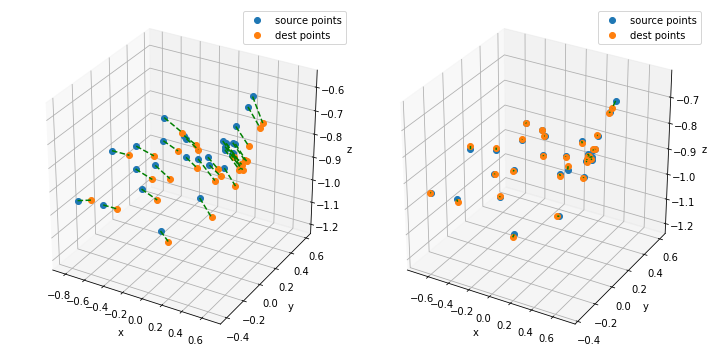

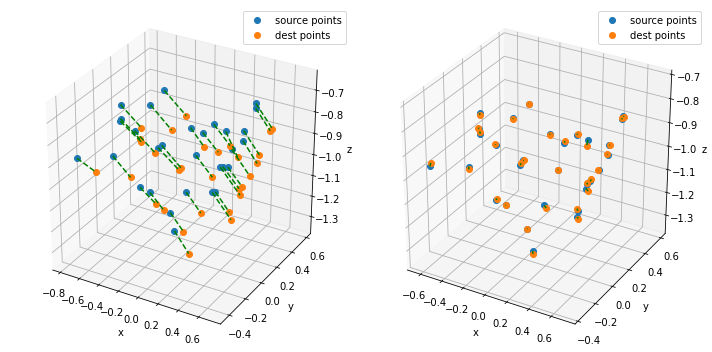

In [107]:
for i in range(len(tr_mxs)):
    _ = visualise_transf(points[i], points[i+1], regs[i])

In [108]:
np.mean(points[0], axis=0)

array([-0.19284777,  0.10289483, -1.24149978])

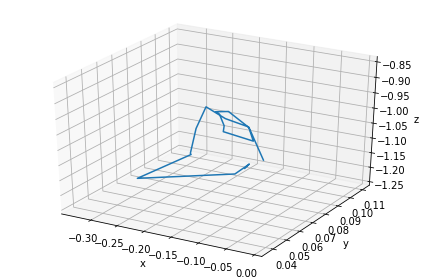

In [109]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
tr = []
for i in range(len(points)):
#     ax.plot(points[i][:50,0], points[i][:50,1], points[i][:50,2], 'o', label=str(i))
    tr.append(np.mean(points[i], axis=0))
tr = np.array(tr)
ax.plot(tr[:,0], tr[:, 1], tr[:, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# ax.legend()

plt.tight_layout()
plt.show()

In [110]:
points_trajectory_T265 = [[0, 0, 0]]
for pose in t265_frames:
    tr_mx = get_transformation265(pose)
    points_trajectory_T265.append(tr_mx[:3, -1])
points_trajectory_T265 = np.array(points_trajectory_T265)

/home/valeryilin/workdir/skoltech/term3/perceptionRobotics/final_pr_team2/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `as_dcm` is deprecated!
as_dcm is renamed to as_matrix in scipy 1.4.0 and will be removed in scipy 1.6.0
  """


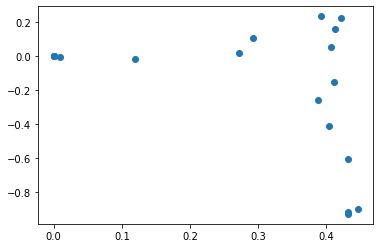

In [111]:
plt.scatter(points_trajectory_T265[:, 1], points_trajectory_T265[:, 2])

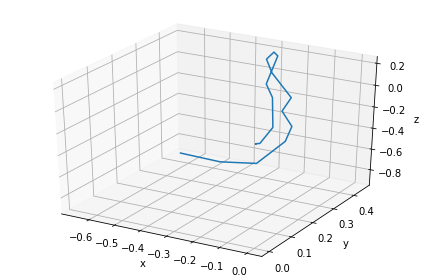

In [112]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.plot(tr[:,0], tr[:, 1], tr[:, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# ax.legend()
ax.plot(points_trajectory_T265[:,0], points_trajectory_T265[:, 1], points_trajectory_T265[:, 2])
plt.tight_layout()
plt.show()

# Visualisation
```
pip install –upgrade pip
pip install PyQT5
```

In [143]:
tr_mxs_real = [tr_mxs[0]]
for i in range(1, len(tr_mxs)):
    tr_mxs_real.append(tr_mxs_real[-1] @ (tr_mxs[i]))

In [144]:
tr_points = [point[:3,-1] for point in tr_mxs_real]

In [149]:
tr_points = np.array(tr_points) * -1

In [150]:
mark_tr_e = [trajectory.tolist().index(i) for i in trajectory.tolist()]
print(mark_tr_e)
mark_tr = [tr_points.tolist().index(i) for i in tr_points.tolist()]
print(mark_tr)

mark_t265 = [t265_translations.tolist().index(i) for i in t265_translations.tolist()]
print(mark_t265)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]


In [158]:
full_t265_trajectory = np.array([get_translation_pose_from_data(pose) for pose in t265_frames_all])

In [159]:
%matplotlib qt
fig = plt.figure(figsize=(10,10), dpi=100)
ax = fig.add_subplot(111, projection='3d')
# ax.plot(tr[:,0], tr[:, 1], tr[:, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# ax.legend()
# ax.plot(trajectory[:,0], trajectory[:, 1], trajectory[:, 2], label='d435_Elvira')
# for i, txt in enumerate(mark_tr_e):
#     ax.text(trajectory[i,0],trajectory[i,1],trajectory[i,2], txt)

ax.plot(tr_points[:,0], tr_points[:, 1], tr_points[:, 2], label='d435_Elvira(post Valera)')
for i, txt in enumerate(mark_tr):
    ax.text(tr_points[i,0],tr_points[i,1],tr_points[i,2], txt)
    
ax.plot(t265_translations[:,0],t265_translations[:,1],t265_translations[:,2], label='t265')
for i, txt in enumerate(mark_t265):
    ax.text(t265_translations[i,0],t265_translations[i,1],t265_translations[i,2], txt)
    
# ax.plot(full_t265_trajectory[:,0],full_t265_trajectory[:,1],full_t265_trajectory[:,2], label='Full trajectory')

plt.tight_layout()
plt.legend()
plt.show()